In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import importlib
import pprint

from interval import interval

import screed

import alignplot
importlib.reload(alignplot)

from alignplot import StackedDotPlot

## another tara genome, this time with two contaminants

In [3]:
if 0:
    dotplot = StackedDotPlot('TARA_PSE_MAG_00132', ('GCA_001550135.1', 'GCA_001641615.1'), 'list.csv', './genomes')
    #dotplot.use_mashmap = True
    x = dotplot()

In [4]:
if 0:
    dotplot = StackedDotPlot('TARA_ANW_MAG_00083', ('GCA_002171995.1',), 'list.csv', './genomes')
    dotplot = StackedDotPlot('GCA_002171995.1', ('TARA_ANW_MAG_00083',), 'list.csv', './genomes')

    dotplot.use_mashmap = True
    x = dotplot()

In [5]:
if 0:
    dotplot = StackedDotPlot('GCA_001550135.1', ('TARA_PSE_MAG_00132', 'GCA_001641615.1'), 'list.csv', './genomes')
    #dotplot.use_mashmap = True
    x = dotplot()

['./genomes/GCA_003220225.1_ASM322022v1_genomic.fna']
found queryfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
found targetfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpj0jqyj43.
shared w/Acidobacteria bacterium: 635.4kb
['./genomes/GCA_003222275.1_ASM322227v1_genomic.fna']
found queryfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
found targetfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp0ztal7wc.
shared w/Candidatus Rokubacteria bacterium: 640.9kb


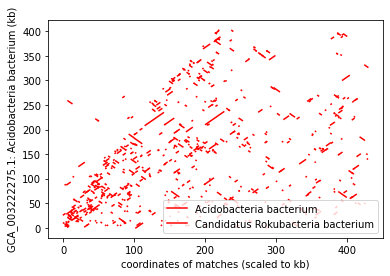

In [39]:
if 1:
    dotplot = StackedDotPlot('GCA_003220225.1',
                             ['GCA_003222275.1',],
                             'list.csv', './genomes')
    _ = dotplot()
    
if 1:
    dotplot2 = StackedDotPlot('GCA_003222275.1',
                             ['GCA_003220225.1'],
                             'list.csv', './genomes')
    _ = dotplot2()


In [40]:
#dotplot = StackedDotPlot('GCA_003222275.1',
#                         ['GCA_003222275.1',],
#                         'list.csv', './genomes')
#_ = dotplot()

## region response curve

underlying logic:

* for our primary use case here (contamination/legitimate "shared" nucleotides), we can consider nt alignments of >= 95% to be contamination to be removed
* we want to remove as many bp of contamination as possible with as little "legit" non-shared nt as possible.
* what's the response curve for that, and can we use it to figure out which genome(s) have the likely contaminants?

In [41]:

def group_regions_by(regions, by_type):
    "gather regions by 'target' or 'query'"

    assert by_type in ('target', 'query')

    regions_by = defaultdict(list)
    for region in regions:
        name = getattr(region, by_type)
        x = regions_by[name]
        x.append(region)
        
    return regions_by

def calc_regions_aligned_bp(regions_by, by_type, filter_by=None):
    assert by_type in ('target', 'query')

    regions_sum_kb = {}
    for name, rr in regions_by.items():
        if filter_by:
            rr = [ r for r in rr if filter_by(r) ]
        if not rr: continue
            
        if by_type == 'target':
            ivals = [ interval[r.tstart, r.tend] for r in rr ]
        elif by_type == 'query':
            ivals = [ interval[r.qstart, r.qend] for r in rr ]
        else:
            raise Exception(by_type)

        ii = interval()
        for iv in ivals:
            ii |= iv
            
        sum_kb = 0
        for component in ii:
            (start, end) = component
            size = end - start
            sum_kb += size
            
        regions_sum_kb[name] = sum_kb
    return regions_sum_kb

def region_size(region, by_type):
    assert by_type in ('target', 'query')
    
    if by_type == 'target':
        return abs(region.tend - region.tstart)
    elif by_type == 'query':
        return abs(region.qend - region.qstart)
    raise Exception(f'unhandled by_type {by_type}')

def load_contig_sizes(genomefile):
    "load in all the actual contig sizes for this genome (in kb)"
    all_sizes = {}
    for record in screed.open(genomefile): # @CTB
        all_sizes[record.name.split()[0]] = len(record.sequence) / 1e3
        
    return all_sizes

def investigate_target_regions(dotplot, t_acc):
    regions = dotplot.results[t_acc]

    # first, find the targetfile (genome) for this accession
    targetfile = dotplot.get_targetfile(t_acc)

    # calculate and sort region summed kb in alignments over 95%
    regions_by_target = group_regions_by(regions, 'target')
    regions_aligned_kb = calc_regions_aligned_bp(regions_by_target, 'target', filter_by = lambda r: r.pident >= 95)
    region_items = list(regions_aligned_kb.items())
    region_items.sort(key = lambda x: -x[1])
    
    # load in all the actual contig sizes for this genome
    all_sizes = load_contig_sizes(targetfile)
    sum_bp = sum(all_sizes.values())

    # construct points for plot --
    x = [] # kb in target contigs
    y = [] # alignments in those target contigs
    sofar = 0
    aligned_sofar = 0
    
    # start with contigs with most aligned bases first - the sorting order matters here!
    for name, ani95_kb in region_items:
        # ok, track total kb and aligned kb added by this contig
        sofar += all_sizes[name]
        aligned_sofar += ani95_kb
        assert all_sizes[name] > 0
    
        x.append(sofar)
        y.append(aligned_sofar)
        
    saturation_point = sofar

    # add in the rest of the contigs that have no alignments in 'em'
    remaining_names = set(all_sizes) - set(region_items)
    for contig in remaining_names:
        sofar += all_sizes[contig]
        x.append(sofar)
        y.append(aligned_sofar)
           
    return numpy.array(x), numpy.array(y), saturation_point

def investigate_query_regions(dotplot):    
    # aggregate regions over _all_ results
    regions = []
    for k, v in dotplot.results.items():
        regions.extend(v)

    queryfile = dotplot.queryfile

    # calculate and sort region summed kb in alignments over 95%
    regions_by_query = group_regions_by(regions, 'query')
    regions_aligned_kb = calc_regions_aligned_bp(regions_by_query, 'query', filter_by = lambda r: r.pident >= 95)
    region_items = list(regions_aligned_kb.items())
    region_items.sort(key = lambda x: -x[1])
    
    # load in all the actual contig sizes for this genome
    all_sizes = load_contig_sizes(queryfile)
    sum_bp = sum(all_sizes.values())

    # construct points for plot --
    x = [] # kb in query contigs
    y = [] # alignments in those query contigs
    sofar = 0
    aligned_sofar = 0
    
    # start with contigs with most aligned bases first - the sorting order matters here!
    for name, ani95_kb in region_items:
        # ok, track total kb and aligned kb added by this contig
        sofar += all_sizes[name]
        aligned_sofar += ani95_kb
        assert all_sizes[name] > 0
    
        x.append(sofar)
        y.append(aligned_sofar)
        
    saturation_point = sofar

    # add in the rest of the contigs that have no alignments in 'em'
    remaining_names = set(all_sizes) - set(region_items)
    for contig in remaining_names:
        sofar += all_sizes[contig]
        x.append(sofar)
        y.append(aligned_sofar)
           
    return numpy.array(x), numpy.array(y), saturation_point

t_acc = dotplot.t_acc_list[0]
x, y, _ = investigate_target_regions(dotplot, t_acc)

759.8299999999999 4727.576999999999


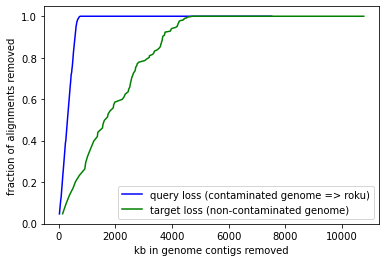

In [46]:
# worry about duplicate bad kb
t_acc = dotplot.t_acc_list[0]
x, y, sat1 = investigate_target_regions(dotplot, t_acc)

#t_acc = dotplot2.t_acc_list[0]
#x2, y2, sat2 = investigate_target_regions(dotplot2, t_acc)

x3, y3, sat3 = investigate_query_regions(dotplot)

plt.plot(x, y / max(y), 'b-', label='query loss (contaminated genome => roku)')
plt.plot(x3, y3 / max(y3), 'g-', label='target loss (non-contaminated genome)')


plt.xlabel('kb in genome contigs removed')
plt.ylabel('fraction of alignments removed')
plt.legend(loc='lower right')
plt.savefig('/tmp/acido-target.png')
print(sat1, sat2)